In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fine-tuned-bart/config.json
/kaggle/input/fine-tuned-bart/merges.txt
/kaggle/input/fine-tuned-bart/trainer_state.json
/kaggle/input/fine-tuned-bart/training_args.bin
/kaggle/input/fine-tuned-bart/training_args.json
/kaggle/input/fine-tuned-bart/vocab.json
/kaggle/input/fine-tuned-bart/tokenizer_config.json
/kaggle/input/fine-tuned-bart/model.safetensors
/kaggle/input/fine-tuned-bart/special_tokens_map.json
/kaggle/input/fine-tuned-bart/generation_config.json


In [2]:
pip install transformers[torch] tokenizers datasets evaluate rouge_score huggingface_hub --upgrade

Note: you may need to restart the kernel to use updated packages.


## Import the necessary libraries

In [3]:
import nltk
import evaluate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

2024-07-30 12:10:31.844692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 12:10:31.844813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 12:10:31.971637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the dataset

In [4]:
dataset = load_dataset("toughdata/quora-question-answer-dataset")

Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 56402
    })
})

## EDA(Exploratory Data Analysis)

#### 1. Analysing the different characters present in the dataset. Since the dataset comprises of charcaters from various languages, unique charcaters and symbols along with emojis and a variety of punctuations can be seen in the dataset.

In [ ]:
# !pip install emoji
import string, emoji

def categorize_character(char):
    if char.isalpha():
        return 'alphabetical'
    if char.isdigit():
        return 'numeric'
    if char in string.punctuation:
        return 'punctuation'
    if char in emoji.EMOJI_DATA:
        return 'emoji'
    return 'other'

def get_unique_characters(text):
    return {char: categorize_character(char) for char in set(text)}

In [22]:
# Concatenating data from both columns and extracting all unique characters
all_text = ' '.join(dataset["train"]['question']) + ' ' + ' '.join(dataset["train"]['answer'])

unique_chars = get_unique_characters(all_text)

categories = {key: [] for key in ['alphabetical', 'numeric', 'punctuation', 'emoji', 'other']}

for char, category in unique_chars.items():
    categories[category].append(char)

In [23]:
print("Character Categories:")
for category, chars in categories.items():
    if chars:
        print(f"\nCategory: {category}")
        print(", ".join(sorted(chars)))

Character Categories:

Category: alphabetical
A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, ª, µ, º, À, Á, Â, Å, Æ, Ç, È, É, Í, Î, Ñ, Ó, Ö, Ø, Ù, Ú, Ü, Þ, ß, à, á, â, ã, ä, å, æ, ç, è, é, ê, ë, ì, í, î, ï, ð, ñ, ò, ó, ô, õ, ö, ø, ù, ú, û, ü, ý, Ā, ā, ă, Ą, ą, Ć, ć, č, Đ, Ē, ē, ė, Ę, ę, ě, Ğ, ğ, ġ, ģ, ĩ, Ī, ī, į, İ, ı, ķ, ĺ, ł, Ń, ń, ņ, ŋ, ō, œ, Ř, Ś, ś, Ş, ş, Š, š, Ţ, ţ, ū, Ŷ, ź, Ż, ż, Ə, ƚ, ƿ, ǫ, ș, Ț, ț, ɐ, ɑ, ɒ, ɔ, ɕ, ɘ, ə, ɛ, ɜ, ɡ, ɦ, ɪ, ɯ, ɾ, ɿ, ʁ, ʃ, ʊ, ʌ, ʏ, ʑ, ʒ, ʔ, ʜ, ʬ, ʰ, ʷ, ʹ, ʻ, ʾ, ʿ, ˈ, ˊ, ˌ, ˍ, ː, Ά, Έ, Β, Δ, Θ, Μ, Π, Σ, Φ, Ω, ά, έ, ή, ί, α, β, γ, δ, ε, η, θ, ι, κ, λ, μ, ν, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω, ϊ, ό, ύ, Ϣ, ϣ, А, Б, В, Г, Д, Е, З, И, К, М, Н, О, П, С, Т, У, Х, Ц, а, б, в, г, д, е, ж, з, и, й, к, л, м, н, о, п, р, с, т, у, ф, х, ц, ч, ш, щ, ы, ь, э, ю, я, є, ѕ, і, ї, ү, א, ב, ג, ד, ה, ז, י, כ, ל, נ, ץ, צ, ר, ء, آ, أ, ؤ, ئ, ا, ب, ة, ت, ث, ج, ح, خ, د, ذ, 

#### 2. Plotting the lengths of questions and answers(number of characters) against the number of times they appear

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


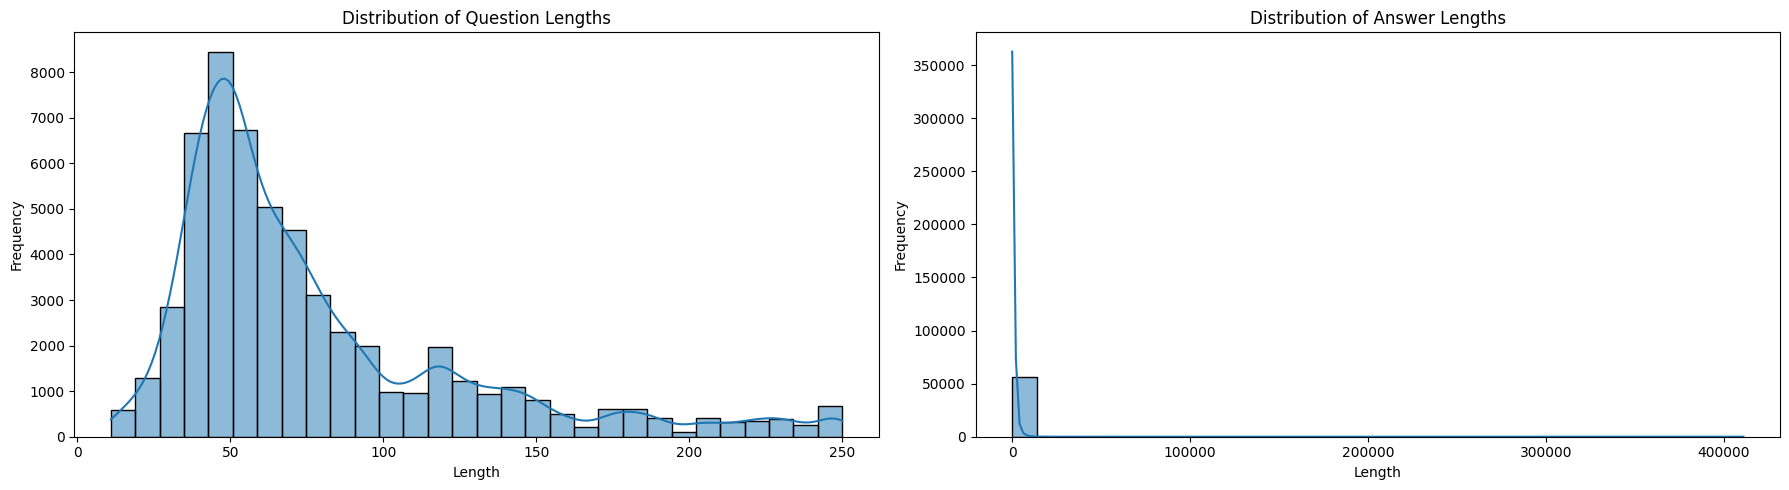

In [31]:
question_lengths = [len(question) for question in dataset['train']['question']]
answer_lengths = [len(answer) for answer in dataset['train']['answer']]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(question_lengths, kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Question Lengths')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

sns.histplot(answer_lengths, kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribution of Answer Lengths')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

## Train-Test Splitting

In [36]:
dataset = dataset["train"].train_test_split(test_size=0.1)

In [41]:
print("Training dataset:")
print(dataset['train'].shape)

print("\nTesting dataset:")
print(dataset['test'].shape)

Training dataset:
(50761, 2)

Testing dataset:
(5641, 2)


## Preprocessing

#### Loading the BART tokenizer and model from checkpoint and DataCollatorForSeq2Seq for batching and padding

In [29]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [31]:
prefix = "Answer the question: "

# Define our preprocessing function
def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    
    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocessing function across our dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/50761 [00:00<?, ? examples/s]

Map:   0%|          | 0/5641 [00:00<?, ? examples/s]

## Evaluaion metric - ROUGE

In [ ]:
# Set up Rouge score for evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

## Training BART on dataset

In [32]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/final_result",
    evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    push_to_hub=False,
    gradient_accumulation_steps=4,
    fp16=True
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,1.132500,1.063885,0.111639,0.029408,0.091875,0.102407
1,1.036700,1.030965,0.115431,0.032482,0.094971,0.105724


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=3172, training_loss=1.1475600667138117, metrics={'train_runtime': 6997.884, 'train_samples_per_second': 14.508, 'train_steps_per_second': 0.453, 'total_flos': 7735802662748160.0, 'train_loss': 1.1475600667138117, 'epoch': 1.9993696816892532})

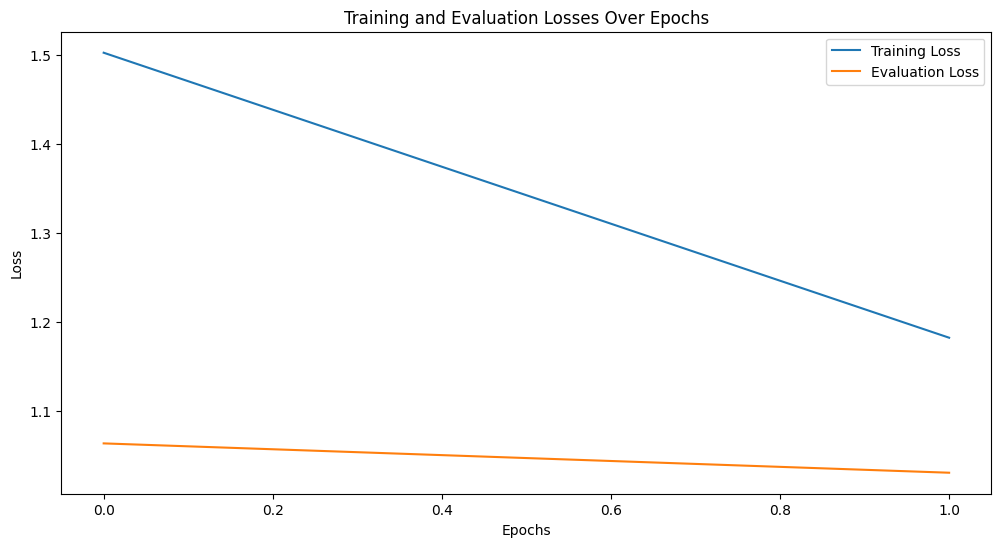

In [37]:
# Extracting metrics from the trainer's log history
log_history = trainer.state.log_history

# Extracting training and evaluation losses
train_losses = [x["loss"] for x in log_history if "loss" in x]
eval_losses = [x["eval_loss"] for x in log_history if "eval_loss" in x]

# Get the minimum length to ensure the lists are the same size
min_length = min(len(train_losses), len(eval_losses))
train_losses = train_losses[:min_length]
eval_losses = eval_losses[:min_length]
epochs = range(min_length)

# Plotting the training and evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, eval_losses, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.show()


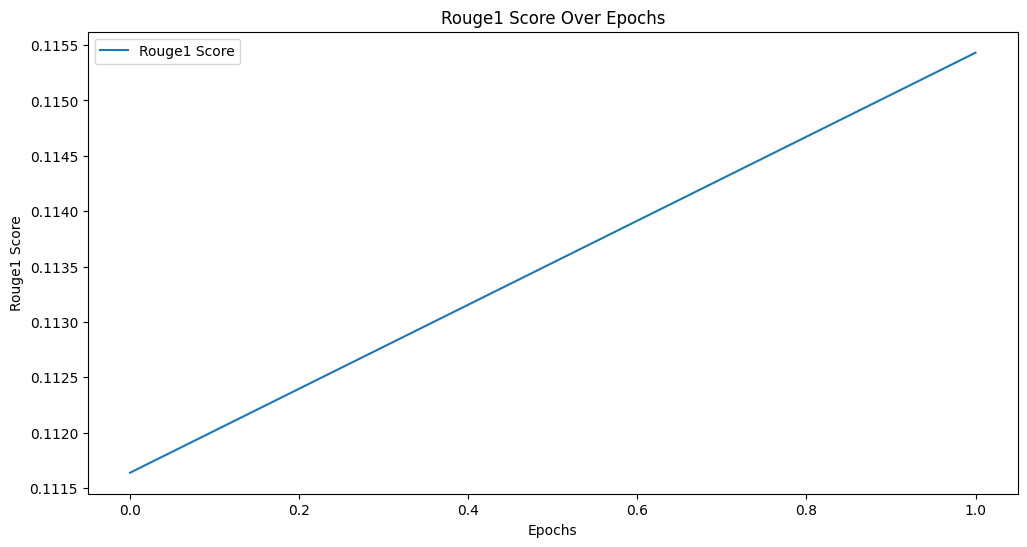

In [38]:
# Extracting metrics from the trainer's log history
log_history = trainer.state.log_history

# Extracting training and evaluation losses
train_losses = [x["loss"] for x in log_history if "loss" in x]
eval_losses = [x["eval_loss"] for x in log_history if "eval_loss" in x]
rouge1_scores = [x["eval_rouge1"] for x in log_history if "eval_rouge1" in x]

# Plotting Rouge1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, rouge1_scores, label='Rouge1 Score')
plt.xlabel('Epochs')
plt.ylabel('Rouge1 Score')
plt.title('Rouge1 Score Over Epochs')
plt.legend()
plt.show()


## Testing on some sample questions

In [8]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the fine-tuned model and tokenizer
model = BartForConditionalGeneration.from_pretrained("/kaggle/input/fine-tuned-bart")
tokenizer = BartTokenizer.from_pretrained("/kaggle/input/fine-tuned-bart")

# List of different input texts
input_texts = [
    "I am feeling lonely", 
    "I need a new job!",
    "I've been struggling to keep up with my studies lately. The workload seems overwhelming, and I'm not sure how to manage my time effectively. What strategies can I use to stay organized and ensure I'm not falling behind in my classes?"  # Long input
]

# Process each input and generate a response
for input_text in input_texts:
    # Tokenize the input
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    
    # Generate response with adjusted parameters
    output_ids = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        temperature=0.7,
        top_p=0.9,
        early_stopping=True
    )
    
    # Decode the output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Print the results
    print(f"Question: {input_text}")
    print(f"Answer: {output_text}\n")


Question: I am feeling lonely
Answer: I’m feeling lonely.
 I’ve been feeling lonely for a while now. I think it’s because of the way people treat me. I don’t want to be alone. I want to feel like I belong.


Question: I need a new job!
Answer: If you are looking for a new job, there are several options available. Here are a few popular options:
 1. [LINKED_TEXT: Fiverr] [URL: https://go.fiverr.com/visit/?bta=7885&brand=fiverrcpa&landingPage=https%3A%2F%2B%2Csearch%2Dsearch%3Dquery%2Deleted%2

Question: I've been struggling to keep up with my studies lately. The workload seems overwhelming, and I'm not sure how to manage my time effectively. What strategies can I use to stay organized and ensure I'm not falling behind in my classes?
Answer: I’ve been struggling to keep up with my studies lately. The workload seems overwhelming, and I’m not sure how to manage my time effectively. Here are some strategies you can use to stay organized and ensure you aren’t falling behind in your classes:
